# **PYTHON AVANZADO**
# **PROYECTO 2**


---



# *Segunda Parte*


---



## *INTRODUCCIÓN*

Este trabajo utiliza un modelo de regresión lineal múltiple para analizar cómo distintas características de los ***autos usados*** influyen en su precio. El objetivo principal es estimar valores aproximados y, al mismo tiempo, comprender qué factores tienen mayor peso en la determinación del valor de mercado.
Este proyecto ofrece una herramienta sencilla para aproximar precios y aporta información útil sobre los factores que más influyen en la valoración de los autos usados.

### Importando librerías y módulos necesarios

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Carga de Datos y visualización de variables

### Cargar el CSV de Datos de autos Usados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto 2 Python avanzado/datos_autos_usados.csv')

### Exploración y análisis inicial
Para ello leeremos el csv con pandas(pasandolo a un dataframe)

In [ ]:
df.head()

,edad_vendedor,edad_auto,km_recorridos,reparaciones,tipo,precio
0,23,2.17,25142.768002,24,0,4077
1,26,18.92,120164.547502,17,0,2804
2,35,24.90,90244.499657,13,0,4432
3,34,1.93,15384.326615,18,0,5340
4,67,6.88,32319.146178,19,0,4053


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   edad_vendedor  1000 non-null   int64  
 1   edad_auto      1000 non-null   float64
 2   km_recorridos  1000 non-null   float64
 3   reparaciones   1000 non-null   int64  
 4   tipo           1000 non-null   int64  
 5   precio         1000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


,edad_vendedor,edad_auto,km_recorridos,reparaciones,tipo,precio
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,46.152000,20.59965,82377.836218,12.807000,0.187000,4354.076000
std,16.866576,11.28514,49873.724305,7.395569,0.390107,1960.881333
min,18.000000,1.00000,14738.735614,0.000000,0.000000,-1543.000000
25%,32.000000,10.72750,42881.726662,6.000000,0.000000,3048.000000
50%,46.000000,20.87500,70263.224727,13.000000,0.000000,4310.500000
75%,61.000000,30.29000,111688.819188,19.000000,0.000000,5758.250000
max,75.000000,39.99000,239619.058017,25.000000,1.000000,10523.000000


En este primer análisis del dataset confirmamos que todas las columnas contienen 1000 datos completos, sin valores faltantes, lo cual permite trabajar directamente sin necesidad de imputaciones. A partir de las estadísticas descriptivas observamos que el promedio de edad de los autos ronda los 20 años y que los vehículos presentan, en promedio, más de 82.000 km recorridos. También se aprecia una gran variabilidad en los kilómetros y en el precio, lo que sugiere que el dataset incluye autos de muy diferentes condiciones. La variable tipo tiene valores entre 0 y 1, indicando que es una categoría binaria. En general, esta etapa permite entender la distribución de los datos y confirmar que se encuentran en condiciones adecuadas para iniciar el análisis y la construcción del modelo de regresión.

## 2.   Cambio de estructura de datos a matricial



### Visualizando los datos con matriz

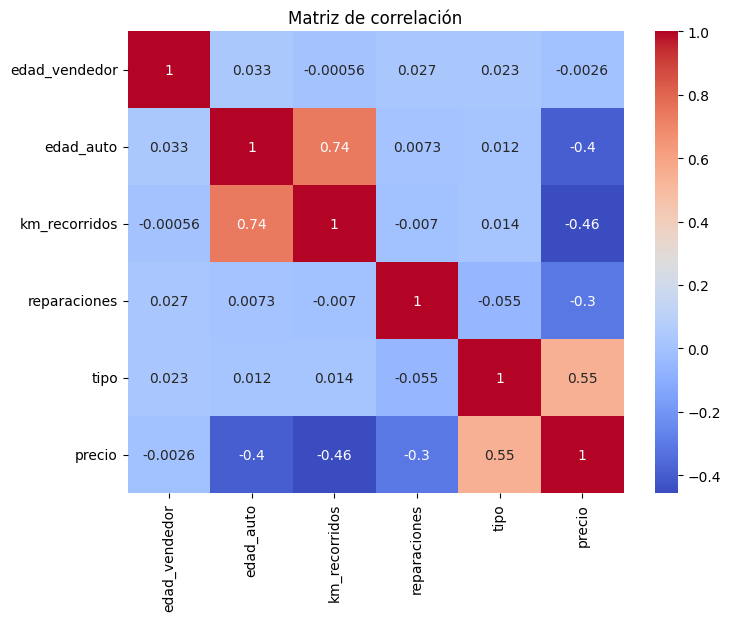

In [ ]:
#Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")#df.corr() calcula la matriz de correlación de las columnas numéricas del DataFrame
#dibuja el mapa de calor,annot=True muestra los valores numéricos dentro de cada celda y cmap="coolwarm" usa una paleta de colores que va de azul (correlación negativa) a rojo (correlación positiva).
plt.title("Matriz de correlación")
plt.show()

#seaborn.heatmap() acepta directamente un DataFrame como entrada, porque internamente sabe cómo manejar tanto arrays de NumPy como DataFrames de Pandas


In [ ]:
correlaciones = df.corr()['precio'].sort_values(ascending=False)
correlaciones
# Edad_vendedor,reparaciones,edad_auto,km_recorridos son correlaciónes negativa perfecta (cuando una sube, la otra baja) = A mayor Edad_vendedor,reparaciones,edad_auto,km_recorridos es menor el precio
#tipo es correlacion positiva = algunos tipos tienden a tener precios mas altos

,precio
precio,1.000000
tipo,0.549643
edad_vendedor,-0.002572
reparaciones,-0.304918
edad_auto,-0.396853
km_recorridos,-0.457345


Elegir qué variables usar como features para predecir una variable objetivo(como precio) depende de cuán fuerte y significativa sea la correlación entre ellas.

* 0.5 o < –0.5	Fuerte relación	= Muy recomendable
* 0.3 a 0.5 / –0.3 a –0.5	Moderada	= Útil, pero revisar


1. tipo	+0.55= fuerte positiva
2. edad_auto	–0.46= moderada negativa
3. km_recorridos	–0.46= moderada negativa


***Interpretación de la Matriz de Correlación:***

La matriz de calor nos da la primera pista sobre la influencia de las variables. Observamos que edad_auto y km_recorridos muestran una correlación negativa con el precio, lo cual es intuitivo: a mayor antigüedad o mayor kilometraje, el valor del vehículo tiende a disminuir.

En cambio, la variable tipo presenta una correlación positiva moderadamente fuerte con el precio (alrededor de 0.55), lo que indica que el tipo de vehículo —por ejemplo, si se trata de un auto de menor o mayor categoría— influye de manera importante en su valor. Es decir, ciertos tipos de autos tienden a tener precios base más altos.

Por su parte, las demás variables (edad_vendedor y reparaciones) muestran correlaciones mucho más bajas, lo que sugiere que su relación con el precio es débil y que no tienen un impacto determinante al momento de estimarlo.

### Preparando los datos

Para el entrenamiento del modelo de Regresión Lineal con Scikit-learn, es esencial que los datos estén en una estructura matricial (NumPy array), donde las variables predictoras (X) y la variable objetivo (Y) se separen.

1. Separamos las Features (X), eliminando la columna 'precio' (df.drop("precio", axis=1)).

2. Separamos el Target (Y), que es la columna 'precio'.

Ambos conjuntos se convirtieron a la estructura matricial utilizando .to_numpy().

In [ ]:
# Separar features y target:
X = df.drop("precio", axis=1)  # Features
y = df["precio"]      # target es la variable que representa el resultado que interesa modelar o predecir

#Convertir a matriz NumPy:
X = X.to_numpy()
y = y.to_numpy()

## 3. Particionado de datos en Entrenamiento y Test



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

En este bloque se realizó la separación del conjunto de datos en dos partes: una para entrenar el modelo (training set) y otra para evaluarlo (test set). Se utiliza un 80% de los datos para entrenar y el 20% restante para probar cómo se comporta el modelo frente a información que no vio durante el entrenamiento. Esto permite medir si el modelo es capaz de generalizar y no simplemente memorizar los datos. El parámetro random_state=42 se utiliza para asegurar que la división sea siempre la misma, lo que permite reproducir los resultados.

## 4 - Generación del modelo con los datos de Entrenamiento

In [ ]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

En este bloque se creó una instancia del modelo de regresión lineal y se lo entrena utilizando los datos del conjunto de entrenamiento. Durante el proceso de ajuste (fit), el modelo aprende la relación matemática entre las variables independientes (X_train) y el precio (y_train), encontrando los coeficientes que mejor se ajustan a los datos. En otras palabras, aquí es donde el modelo “aprende” a predecir el precio a partir de las características de cada vehículo.

## 5 - Evaluación del modelo con los datos de Entrenamiento

Entrenar un modelo no alcanza: necesitamos medir qué tan bien funciona.

Llegados a este punto debemos medir el ***error que comete el modelo***, en este caso con los datos de entrenamiento, que son datos que se han utilizado para generar el modelo (o hipótesis).


* Para ello utilizamos 3 medidas de ***Accuracy***:

    1. ***MAE***: Mean Absolute Error (Error Absoluto Medio)
    2. ***MSE***: Mean Squared Error (Error Cuadrático Medio)
    3. ***R2***: Coeficiente de determinación (Raiz del error cuadrático medio)
    
    
* Para calcular esta medidas, necesitamos tener el valor real de la salida y la predicción del modelo.


* Para obtener la predicción del modelo, utilizamos el método ***.predict(X)*** pasándole los datos a predecir y obteniendo el resultado.

In [ ]:
y_train_pred = modelo.predict(X_train) #Genera las predicciones del modelo usando las mismas muestras con las que fue entrenado.Sirve para evaluar qué tan bien “ajustó” el modelo a los datos de entrenamiento.

mae_train = mean_absolute_error(y_train, y_train_pred) #error absoluto medio.Interpretación en unidades de la variable objetivo (precio). Menor es mejor.
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))#raiz del error cuadratico medio.Penaliza más los errores grandes que el MAE. Está en las mismas unidades que el precio. Menor es mejor.
r2_train = r2_score(y_train, y_train_pred)#coeficiente de determinacion.Rango típico: cercano a 1 es mejor; 0 significa que no mejora frente a predecir el promedio; puede ser negativo si el modelo es peor que el promedio.

print("MAE (Train):", mae_train)
print("RMSE (Train):", rmse_train)
print("R2 (Train):", r2_train)

MAE (Train): 1001.3841351289805
RMSE (Train): 1231.4359409252947
R2 (Train): 0.5897129947908553


El modelo logra explicar aproximadamente el 59% de la variación del precio dentro del conjunto de entrenamiento.
Esto representa un ajuste moderado, porque el modelo captura relaciones importantes pero todavía hay factores que influyen en el precio y que no están en el dataset.

El error promedio de alrededor de $1000 indica que el modelo predice razonablemente bien, pero no con extrema precisión, lo cual es esperable dada la naturaleza simple de las variables.
RMSE (Root Mean Squared Error) = 1231.43

Similar al MAE. Como es mayor que el MAE, indica que hay algunos autos donde el modelo se equivoca bastante más que el promedio.

## 6 - Evaluación del modelo con los datos de Test

In [ ]:
y_test_pred = modelo.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("MAE (Test):", mae_test)
print("RMSE (Test):", rmse_test)
print("R2 (Test):", r2_test)

MAE (Test): 1040.8655297779412
RMSE (Test): 1262.0659646509027
R2 (Test): 0.6364242618047427


Si las métricas son similares en ambos, el modelo generaliza bien:

Este modelo explica alrededor del 63% de la variación del precio en datos nuevos (no vistos).
Esto es un rendimiento moderadamente bueno, y el hecho de que el R² de Test sea mayor que el de Train indica que:

* El modelo generaliza bien (porque en train y test las métricas son similares de MAE y RMSE)
* No hay overfitting es decir,no está memorizando los datos (porque en train y test las métricas son similares de R2)

El error promedio en Test (≈ $1040) es coherente con el del Train, lo cual refuerza que el modelo es estable.

In [ ]:
#Coeficientes del modelo
coeficientes = pd.DataFrame({
    "Feature": df.drop("precio", axis=1).columns,
    "Coeficiente": modelo.coef_
})
coeficientes

,Feature,Coeficiente
0,edad_vendedor,1.537575
1,edad_auto,-24.903286
2,km_recorridos,-0.014127
3,reparaciones,-71.140598
4,tipo,2598.408248


Los coeficientes permiten conocer la influencia de cada variable en el precio :

**Variable    Coeficiente Interpretación breve**

* edad_vendedor = +1.53: Prácticamente no influye en el precio.
* edad_auto= –24.90: Autos más viejos valen menos, como es lógico.
* km_recorridos= –0.014: A más kilometraje, menor precio, pero con efecto suave.
* reparaciones= –71.14: Cada reparación adicional baja el precio aprox. $70.
* tipo= +2598.41: Es la variable más influyente: el tipo de auto determina gran parte del precio.

En conclusión, la variable tipo domina totalmente el impacto, mientras que el resto ajusta el precio en menor medida.
Esto es coherente con la realidad: el tipo de auto (SUV, camioneta, sedán…) define el rango de precio base.

/tmp/ipython-input-1406502085.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeficientes.sort_values("Coeficiente"),


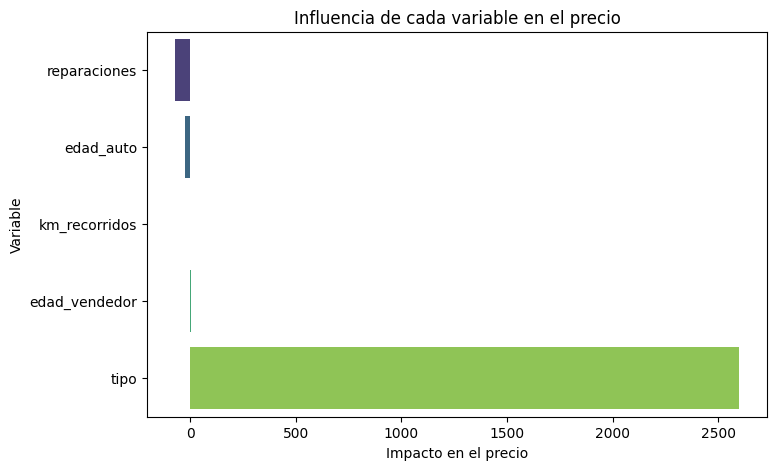

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=coeficientes.sort_values("Coeficiente"),
            x="Coeficiente", y="Feature", palette="viridis")
plt.title("Influencia de cada variable en el precio")
plt.xlabel("Impacto en el precio")
plt.ylabel("Variable")
plt.show()

El gráfico muestra claramente que:

* Tipo es la variable con mayor influencia positiva sobre el precio.
* Edad_auto, km_recorridos y reparaciones tienen impacto negativo, lo cual es esperable: autos más viejos, con más uso o más reparaciones valen menos.
* Edad_vendedor prácticamente no afecta el precio.


La diferencia visual es tan grande que confirma que el tipo de auto es determinante y domina el comportamiento del modelo.

#Conclusiones

El modelo de regresión lineal múltiple permitió analizar de qué manera, diferentes características de los autos usados influyen en su precio, obteniendo un desempeño moderado pero consistente. A partir de las métricas calculadas tanto en el entrenamiento como en la prueba, puede observarse que los valores de R² se mantienen relativamente estables (aproximadamente 0.59 en entrenamiento y 0.63 en test), lo que indica que el modelo es capaz de explicar alrededor del 60% de la variación del precio utilizando las variables disponibles. Este comportamiento, sumado a que el error en test (MAE ≈ 1040 y RMSE ≈ 1262) es similar al observado en entrenamiento, muestra que el modelo generaliza adecuadamente y no presenta signos de sobreajuste.

El análisis de los coeficientes permitió identificar qué variables influyen más en las predicciones. Entre ellas, la variable tipo del vehículo resultó ser ampliamente la más significativa, con un impacto positivo de aproximadamente $2600 sobre el precio, lo que refleja que la categoría o segmento del auto define en gran medida su valor de mercado. Por otro lado, variables como edad del auto, kilómetros recorridos y cantidad de reparaciones presentaron coeficientes negativos, lo cual es coherente con la depreciación esperada: autos más viejos, con más uso o con más reparaciones tienden a valer menos. La edad del vendedor mostró un efecto mínimo, prácticamente irrelevante en términos predictivos.

En conjunto, las variables utilizadas pueden considerarse predictores aceptables, aunque no totalmente determinantes. Logran explicar parte importante del precio, pero todavía dejan una porción considerable de variabilidad sin capturar, lo cual es comprensible dado que faltan atributos clave como marca, motor, versión, equipamiento, estado general o historial del vehículo. Aun así, con la información disponible, el modelo logra un equilibrio razonable entre simplicidad y capacidad explicativa.

Finalmente, la comparación entre el rendimiento en entrenamiento y prueba confirmó que el modelo mantiene un comportamiento estable y sin pérdida de calidad al enfrentarse a nuevos datos. El ajuste es moderado, las conclusiones obtenidas tienen sentido práctico y los patrones identificados coinciden con la lógica habitual del mercado automotor. El modelo, por lo tanto, resulta útil para realizar estimaciones aproximadas del precio y para comprender cuáles variables actúan con mayor peso en su determinación.